<a href="https://colab.research.google.com/github/mukesh527/Traffic_Sign_Classification_with_CNN/blob/main/TS_classificationv2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
from tensorflow.keras.utils import to_categorical

os.chdir('/content/gdrive/MyDrive/CNN/Traffic sign classification/FullIJCNN2013/')
os.getcwd()


'/content/gdrive/MyDrive/CNN/Traffic sign classification/FullIJCNN2013'

#Code to crop the image


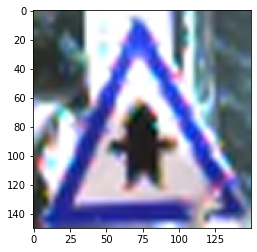

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img=cv2.imread('00000.ppm')
plt.imshow(img)
cropped=img[411:446,774:816]
cropped.shape
cropped = cv2.resize(cropped, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
plt.imshow(cropped)


#Function to crop image


In [5]:
def crop(img,left,top,right,bottom):
  img=cv2.imread(img)
  crop=img[top:bottom,left:right]
  crop=crop/255.0
  crop=cv2.resize(crop,dsize=(150,150),interpolation=cv2.INTER_CUBIC)
  return crop

In [6]:
import pandas as pd
gt=pd.read_csv('/content/gdrive/MyDrive/CNN/Traffic sign classification/FullIJCNN2013/gt.csv',delimiter=';',header=None)
gt.columns=['image_name','leftcol','toprow','rightcol','bottomrow','class']
gt
images=[]
for row in range(0,gt.shape[0]):
  print ('current image......'+str(row))
  images.append(crop(gt.iloc[row,0],gt.iloc[row,1],gt.iloc[row,2],gt.iloc[row,3],gt.iloc[row,4]))


current image......0
current image......1
current image......2
current image......3
current image......4
current image......5
current image......6
current image......7
current image......8
current image......9
current image......10
current image......11
current image......12
current image......13
current image......14
current image......15
current image......16
current image......17
current image......18
current image......19
current image......20
current image......21
current image......22
current image......23
current image......24
current image......25
current image......26
current image......27
current image......28
current image......29
current image......30
current image......31
current image......32
current image......33
current image......34
current image......35
current image......36
current image......37
current image......38
current image......39
current image......40
current image......41
current image......42
current image......43
current image......44
current image......4

In [7]:
datax=np.array(images)
datay=np.array(gt['class'])
datay=to_categorical(datay)
datax.shape

(1213, 150, 150, 3)

#Data Augmentatoin Techniques

In [8]:
gt.shape

(1213, 6)

#Augumentation with rotation


In [9]:
lis_datax=list(datax)
lis_datay=list(datay)
def random_rotation(img,cat):
  samples=expand_dims(img,0)
  datagen = ImageDataGenerator(rotation_range=90)
  it = datagen.flow(samples, batch_size=1)
  
  for i in range(3):
    	
      # generate batch of images
      batch = it.next()
      # convert to unsigned integers for viewing
      lis_datax.append(batch[0].astype('float16'))
      lis_datay.append(cat)
  return lis_datax,lis_datay
    
 


#Augumentation with horizontal and vertical flips


In [10]:
def random_flips(img,cat):
  samples=expand_dims(img,0)
  datagen = ImageDataGenerator(horizontal_flip=True)
  it = datagen.flow(samples, batch_size=1)
  
  for i in range(3):
    	
      # generate batch of images
      batch = it.next()
      # convert to unsigned integers for viewing
      lis_datax.append(batch[0].astype('float16'))
      lis_datay.append(cat)
  return lis_datax,lis_datay
    

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims
for row in range(0,datax.shape[0]):
  #new_datax,new_datay=random_rotation(datax[row],datay[row])
  new_datax,new_datay=random_flips(datax[row],datay[row])



In [12]:
new_datax=np.array(new_datax)
new_datay=np.array(new_datay)
new_datax.shape

(4852, 150, 150, 3)

#Model Building


In [13]:
import sys
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, MaxPool2D,Dense,BatchNormalization
from keras.optimizers import SGD,Adam

In [14]:
def define_model():
  model=Sequential()
  model.add(Conv2D(32,(3,3),activation='relu',padding='same',kernel_initializer='he_uniform',input_shape=(150,150,3)))
  model.add(MaxPool2D(2,2))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_uniform'))
  model.add(MaxPool2D(2,2))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_uniform'))
  model.add(MaxPool2D(2,2))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(43,activation='softmax'))
  opt=SGD(learning_rate=0.001,momentum=0.9)
  model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
  model.save('final_model.h5')
  return model


In [15]:
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	plt.close()

In [30]:
def run_test_harness():
  #load dataset
  trainX,testX,trainY,testY=train_test_split(new_datax,new_datay,test_size=0.3,random_state=42)
  
  model=define_model()
  history=model.fit(trainX,trainY,epochs=20,batch_size=64,validation_data=(testX,testY),verbose=1)
  _,acc=model.evaluate(testX,testY,verbose=0)
  print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)
  return acc*100

In [31]:
run_test_harness()

Epoch 1/20
54/54 [==============================] - 188s 3s/step - loss: 2.7959 - accuracy: 0.3180 - val_loss: 3.2507 - val_accuracy: 0.2699
Epoch 2/20
54/54 [==============================] - 185s 3s/step - loss: 1.7594 - accuracy: 0.5395 - val_loss: 2.9440 - val_accuracy: 0.3599
Epoch 3/20
54/54 [==============================] - 190s 4s/step - loss: 1.3537 - accuracy: 0.6484 - val_loss: 2.6445 - val_accuracy: 0.4368
Epoch 4/20
54/54 [==============================] - 187s 3s/step - loss: 1.1191 - accuracy: 0.7220 - val_loss: 2.5407 - val_accuracy: 0.4361
Epoch 5/20
54/54 [==============================] - 187s 3s/step - loss: 0.9493 - accuracy: 0.7715 - val_loss: 2.1938 - val_accuracy: 0.5034
Epoch 6/20
54/54 [==============================] - 187s 3s/step - loss: 0.7608 - accuracy: 0.8283 - val_loss: 1.9426 - val_accuracy: 0.5282
Epoch 7/20
54/54 [==============================] - 188s 3s/step - loss: 0.6435 - accuracy: 0.8554 - val_loss: 1.4693 - val_accuracy: 0.7026
Epoch 8/20
54

95.39835453033447

#Sample image test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[0.03759564, 0.02239238, 0.04577991, 0.03227396, 0.0259946 ,
        0.02638585, 0.02659403, 0.01985537, 0.02872271, 0.01501608,
        0.02487663, 0.03658009, 0.01457522, 0.01217615, 0.02341899,
        0.01633395, 0.0147353 , 0.0214065 , 0.01710707, 0.01474339,
        0.01418686, 0.02200216, 0.01810107, 0.02271285, 0.0197581 ,
        0.02688188, 0.02685529, 0.02619496, 0.01617466, 0.02962754,
        0.01996208, 0.02271609, 0.0197489 , 0.02380904, 0.03213986,
        0.01171163, 0.02548519, 0.02068057, 0.03336959, 0.02557974,
        0.01617475, 0.02860521, 0.02095812]], dtype=float32)

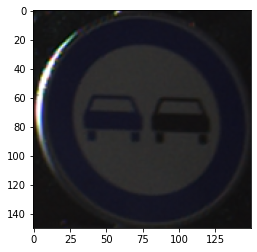

In [56]:
from keras.models import load_model
row=10
timg=crop(gt.iloc[row,0],gt.iloc[row,1],gt.iloc[row,2],gt.iloc[row,3],gt.iloc[row,4])

plt.imshow(timg)

timg=timg.reshape(1,150,150,3)
model=load_model('final_model.h5')
result=model.predict(timg)
result

In [53]:
new_datay[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)